In [1]:
import tensorflow as tf
import numpy as np
from sklearn.preprocessing import StandardScaler, MinMaxScaler
import pandas as pd
from sklearn.model_selection import train_test_split
import sqlite3
import pandas as pd
from pathlib import Path
import os
from matplotlib import pyplot as plt
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, Dropout, LeakyReLU
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.preprocessing.sequence import TimeseriesGenerator

physical_devices = tf.config.list_physical_devices('GPU')
print(physical_devices[0])
tf.config.experimental.set_memory_growth(physical_devices[0], True)

PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')


In [2]:
def import_training_data():

    ''' imports training data as a pandas DataFrame '''

    dir = '../../SQL_Data/constant_setup'
    files = os.listdir(dir)
    files = [f for f in files if f.endswith('.sqlite3')]

    data = []
    for f in files:
        path = os.path.join(dir, f)
        conn = sqlite3.connect(path)
        if os.path.getsize(path) > 10000:
            cur = conn.cursor()
            cur.execute('SELECT * FROM TrainingData')
            df = pd.DataFrame(cur.fetchall())
            data.append(df)

    names = list(map(lambda x: x[0], cur.description))
    df = pd.concat(data)
    df.columns = names
    df = df.drop(['frameIdentifier','bestLapTime', 'pkt_id', 'packetId', 'SessionTime', 'index' ], axis=1)
    df.reset_index()

    print('Data Imported')

    return df

In [3]:
def pad_data(training, target):
    
    max_timesteps = 10000 # max(training, key=len).shape[0]
    num_rows_to_add = [max_timesteps-l.shape[0] for l in training]
    training_pad = []
    target_pad = []
    print(f'max timesteps : {max_timesteps}')
    
    for i in range(len(training)):
        rows_to_add = num_rows_to_add[i]

        training_arr = training[i]
        training_append = np.zeros((rows_to_add, training[0].shape[1]), dtype=float)
        training_array = np.vstack((training_arr, training_append))
        training_pad.append(training_array)

        target_arr = target[i].reshape(target[i].shape[0])
        target_append = np.zeros((rows_to_add), dtype=float)
        target_array = np.concatenate([target_arr, np.zeros(rows_to_add)])
        target_pad.append(target_array)
    
    return training_pad, target_pad

In [4]:
def scale_data(data):
    scalers = {}
    sessionUIDs = data.pop('sessionUID')
    lap_number = data.pop('currentLapNum')
    for i in data.columns:
        scaler = MinMaxScaler()
        s = scaler.fit_transform(data[i].values.reshape(-1,1))
        s = np.reshape(s, len(s))
        scalers['scaler_'+ i ] = scaler
        data[i] = s

    data['sessionUID'] = sessionUIDs
    data['currentLapNum'] = lap_number
    
    return data, scalers

In [5]:
def dataframe_format(data):
    data.reset_index(drop=True, inplace=True)
    
    session_groups = data.groupby('sessionUID')
    samples = []
    targets = []
    total_laps = 0
    
    for s in list(session_groups.groups):
        session = session_groups.get_group(s)
        lap_groups = session.groupby('currentLapNum')
        total_laps += len(lap_groups)
        for l in list(lap_groups.groups):
            lap = lap_groups.get_group(l)
            lap = lap.drop(['sessionUID'], axis=1)
            targ = pd.DataFrame(lap.pop('lap_time_remaining'))
            targets.append(targ)
            samples.append(lap)
    
    sample_cols = list(samples[0].columns)
    target_cols = list(targets[0].columns)

    training = [x.to_numpy() for x in samples]
    target = [y.to_numpy() for y in targets]
    
    training, target = pad_data(training, target)
    
    split = int(total_laps*0.9)

    X_train = training[:split]
    X_test  = training[split:]
    y_train = target[:split]
    y_test  = target[split:]
    
    
    Xtrain = np.concatenate(X_train)
    Xtest  = np.concatenate(X_test)
    Ytrain = np.concatenate(y_train)
    Ytest  = np.concatenate(y_test)
    
    trainX = pd.DataFrame(Xtrain, columns=sample_cols)
    testX  = pd.DataFrame(Xtest, columns=sample_cols)
    trainY = pd.DataFrame()
    testY  = pd.DataFrame()
    
    trainY['lap_time_remaining'] = Ytrain
    testY['lap_time_remaining']  = Ytest
    
    trainX.drop('currentLapNum', axis=1, inplace=True)
    testX.drop('currentLapNum', axis=1, inplace=True)
    
    return trainX, testX, trainY, testY

In [6]:
def single_generator(trainX, testX, trainY, testY):
    ''' Creates train and test generators from data for a single lap/sequence'''

    look_back = 5
    batch_size = 1

    train_generator = tf.keras.preprocessing.sequence.TimeseriesGenerator(trainX, trainY, length=look_back, sampling_rate=1, stride=1, batch_size=batch_size)
    test_generator = tf.keras.preprocessing.sequence.TimeseriesGenerator(testX, testY, length=look_back, sampling_rate=1, stride=1, batch_size=1)

    return train_generator, test_generator

In [8]:
def train_model(model, train_generator):
    ''' training the model'''
    EPOCHS = 10
    callback = [EarlyStopping(monitor="loss", min_delta = 0.0001, patience = 10, mode = 'auto', 
                restore_best_weights=True),
                ModelCheckpoint('generator_lstm.h5')]
    history = model.fit(train_generator, callbacks=callback, shuffle=False, epochs=EPOCHS, batch_size=1)
    return history, model

In [9]:
def build_model(train_generator):

    ''' buils model and prints out summary'''
    trainX, trainY = train_generator[0]

    learning_rate = 0.001
    units = 128
    epochs = 100
    from tensorflow.keras.models import Sequential
    from tensorflow.keras.layers import Dense, LSTM, Dropout, LeakyReLU
    from tensorflow.keras.callbacks import EarlyStopping

    model = Sequential()
    model.add(tf.keras.layers.Masking(mask_value=0., input_shape=(trainX.shape[1], trainX.shape[2])))
    model.add(LSTM(units, ))
    model.add(LeakyReLU(alpha=0.5))
    model.add(Dropout(0.1))
    model.add(Dense(1))

    adam = tf.keras.optimizers.Adam(lr=learning_rate)

    model.compile(optimizer=adam, loss='mse', metrics=['mae'])

    print(model.summary())

    print('Model Built')

    return model

In [10]:
data = import_training_data()

Data Imported


In [11]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1628590 entries, 0 to 80681
Data columns (total 50 columns):
 #   Column                     Non-Null Count    Dtype  
---  ------                     --------------    -----  
 0   lastLapTime                1628590 non-null  float64
 1   currentLapTime             1628590 non-null  float64
 2   currentLapNum              1628590 non-null  int64  
 3   finalLapTime               1628590 non-null  float64
 4   lapDistance                1628590 non-null  float64
 5   carPosition                1628590 non-null  int64  
 6   sector                     1628590 non-null  int64  
 7   sessionUID                 1628590 non-null  object 
 8   worldPositionX             1628590 non-null  float64
 9   worldPositionY             1628590 non-null  float64
 10  worldPositionZ             1628590 non-null  float64
 11  worldVelocityX             1628590 non-null  float64
 12  worldVelocityY             1628590 non-null  float64
 13  worldVelocityZ

In [12]:
# data = pd.read_csv('sample_data.csv')

data, scalers = scale_data(data)

train_X, test_X, train_Y, test_Y = dataframe_format(data)

trainX = train_X.to_numpy()
testX  = test_X.to_numpy()
trainY = train_Y.to_numpy()
testY = test_Y.to_numpy()


train_generator, test_generator = single_generator(trainX, testX, trainY, testY)

model = build_model(train_generator)


max timesteps : 10000
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
masking (Masking)            (None, 5, 47)             0         
_________________________________________________________________
lstm (LSTM)                  (None, 128)               90112     
_________________________________________________________________
leaky_re_lu (LeakyReLU)      (None, 128)               0         
_________________________________________________________________
dropout (Dropout)            (None, 128)               0         
_________________________________________________________________
dense (Dense)                (None, 1)                 129       
Total params: 90,241
Trainable params: 90,241
Non-trainable params: 0
_________________________________________________________________
None
Model Built


In [13]:
history, model = train_model(model, train_generator)

Epoch 1/10
2009995/2009995 [==============================] - 10522s 5ms/step - loss: 3.7616e-04 - mae: 0.0082
Epoch 2/10
2009995/2009995 [==============================] - 10521s 5ms/step - loss: 2.5367e-04 - mae: 0.0073
Epoch 3/10
2009995/2009995 [==============================] - 10462s 5ms/step - loss: 2.6395e-04 - mae: 0.0073
Epoch 4/10
2009995/2009995 [==============================] - 10447s 5ms/step - loss: 3.1310e-04 - mae: 0.0074
Epoch 5/10
2009995/2009995 [==============================] - 10450s 5ms/step - loss: 2.9481e-04 - mae: 0.0073
Epoch 6/10
2009995/2009995 [==============================] - 10440s 5ms/step - loss: 4.0415e-04 - mae: 0.0074
Epoch 7/10
2009995/2009995 [==============================] - 10484s 5ms/step - loss: 3.8293e-04 - mae: 0.0074
Epoch 8/10
2009995/2009995 [==============================] - 10656s 5ms/step - loss: 6.7983e-04 - mae: 0.0076
Epoch 9/10
 908839/2009995 [============>.................] - ETA: 1:50:44 - loss: 8.5354e-04 - mae: 0.0090

KeyboardInterrupt: 

In [14]:
def make_predictions(model, test_generator, scalers):
    preds = scalers['scaler_lap_time_remaining'].inverse_transform(model.predict(test_generator))
    return preds

model = tf.keras.models.load_model('generator_lstm.h5')
pred = make_predictions(model, test_generator, scalers)

In [15]:

test_Y['time_remaining_descaled'] = scalers['scaler_lap_time_remaining'].inverse_transform(test_Y['lap_time_remaining'].to_numpy().reshape(-1,1))

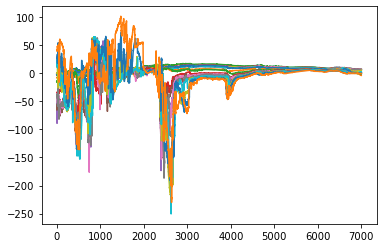

In [42]:
p = pred.T
preds = []
predictions_df = pd.DataFrame()
l = 0
i_prev = 0

for i in range(10000, p.shape[1], 10000):
    predictions_df[f'lap_{l}'] = p[0][i_prev:i]
    i_prev = i
    
for i in p:
    preds.append(pd.Series(np.concatenate([i, np.zeros(5)]))) 


    
predictions=pd.concat(preds)

predictions_df = pd.DataFrame()
l = 0
i_prev = 0


for i in range(10000, len(predictions), 10000):
    predictions_df[f'lap_{l}'] = predictions.to_list()[i_prev:i]
    i_prev = i
    l+=1

test_Y['predictions'] = predictions
    
# display(predictions_df.head())

err = test_Y['time_remaining_descaled'] - test_Y['predictions']
err = err.to_list()

i_prev = 0

for i in range(10000, len(err), 10000):
    plt.plot(err[i_prev:i-3000])
    i_prev = i
plt.show()

for i in range(len(list(predictions_df.columns))):
    lap = predictions_df[f'lap_{i}']
    lap = lap[:7000]
    predictions_df[f'lap_{i}'] = lap
 


# predictions_df.plot()

    


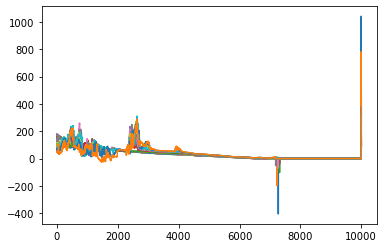

In [21]:
lap = 1
labels = []
i_prev = 0
for i in range(10000, len(test_Y), 10000):
    plt.plot(test_Y['predictions'].to_list()[i_prev:i])
    labels.append(lap)
    i_prev = i
    lap+=1
    
plt.show()

